In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
def enhance_auto_adaptive(img_path):
    # --- Step 0: Load and Convert Image ---
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # --- Step 1: Gentle Gamma Correction ---
    gamma = 1.05
    img_gamma = np.power(img / 255.0, gamma)
    img_gamma = np.uint8(np.clip(img_gamma * 255, 0, 255))

    # --- Step 2: Soft CLAHE (Balanced) ---
    lab = cv2.cvtColor(img_gamma, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8, 8))
    l_eq = clahe.apply(l)
    lab_eq = cv2.merge((l_eq, a, b))
    img_clahe = cv2.cvtColor(lab_eq, cv2.COLOR_LAB2RGB)

    # --- Step 3: Gentle Desaturation ---
    hsv = cv2.cvtColor(img_clahe, cv2.COLOR_RGB2HSV)
    hsv[..., 1] = np.clip(hsv[..., 1] * 0.9, 0, 255)
    img_balanced = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    # --- Step 4: Deep Denoise (Edge-Preserving + Shadow Smoothing) ---
    # Bilateral filter preserves edges but smooths texture
    smooth = cv2.bilateralFilter(img_balanced, d=9, sigmaColor=75, sigmaSpace=75)

    # Then apply Non-local Means for final cleanup
    denoised = cv2.fastNlMeansDenoisingColored(smooth, None, h=10, hColor=10, templateWindowSize=7, searchWindowSize=21)

    # Blend dark areas more toward denoised result (adaptive shadow cleanup)
    gray = cv2.cvtColor(img_balanced, cv2.COLOR_RGB2GRAY)
    dark_mask = cv2.normalize(255 - gray, None, 0, 1.0, cv2.NORM_MINMAX)
    dark_mask = cv2.GaussianBlur(dark_mask, (9,9), 5)
    img_clean = np.uint8((1 - dark_mask[..., None]) * img_balanced + dark_mask[..., None] * denoised)

    # --- Step 5: Precision Sharpen (Soft Unsharp Mask) ---
    blur = cv2.GaussianBlur(img_clean, (0,0), 1.5)
    img_sharp = cv2.addWeighted(img_clean, 1.15, blur, -0.15, 0)

    # --- Step 6: Optional: Final Subtle Tone Compression (for cinematic feel) ---
    img_final = np.clip(np.power(img_sharp / 255.0, 0.95) * 255, 0, 255).astype(np.uint8)

    # --- Display ---
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1); plt.imshow(img); plt.title("Original"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(img_final); plt.title("Enhanced (Clean + Sharp)"); plt.axis("off")
    plt.show()

    return img_final


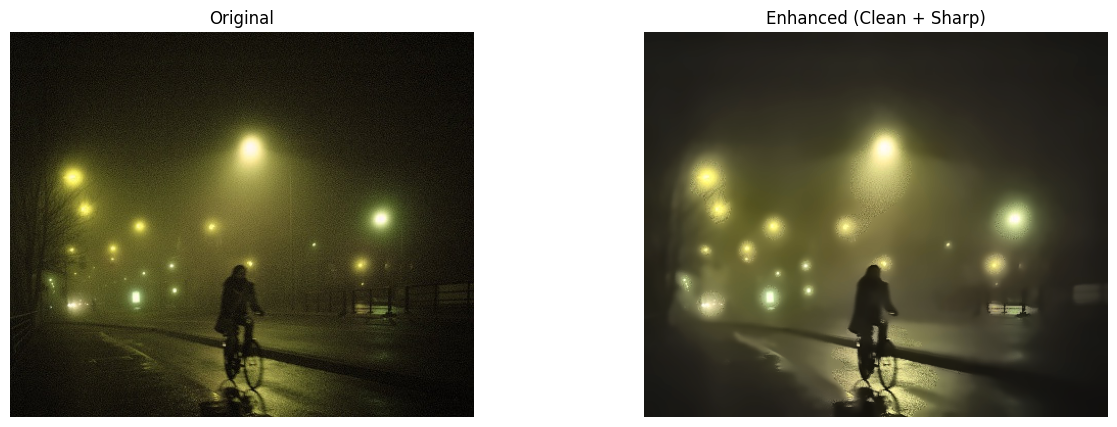

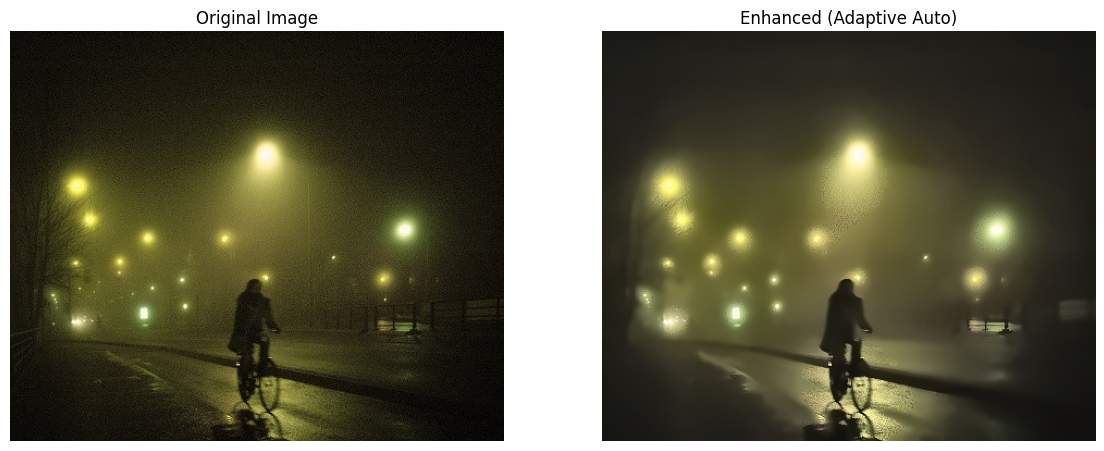

In [27]:
img_path = "assets/gambar2.jpg"

original = cv2.imread(img_path)
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

enhanced = enhance_auto_adaptive(img_path)

plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(original)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(enhanced)
plt.title("Enhanced (Adaptive Auto)")
plt.axis("off")
plt.show()
